In [48]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [59]:
import sys

sys.path.append("../")

In [60]:
import os
import jax
import numpy as np

from jax import random
from matplotlib import pyplot as plt

In [61]:
from playground.sim_clr import constants, utils, data_prep, trainer

In [62]:
# downloads the pretrained resnet model
utils.download_pre_trained()

In [63]:
# takes the original dataset, applies transformation (randomresizedcrop) to get two auguments for each image.
# thus at each row we have two augumentations of the same image
unlabeled_data, train_data_contrast = data_prep.get_stl_dataset(constants.DATASET_PATH)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
idx = 0
# 0th index contain the image, and 1st index contain label (-1 in case of unlabelled data)
data_prep.parallel_augment(
    random.PRNGKey(idx), np.stack(unlabeled_data[idx][0], axis=0)
).shape

(2, 96, 96, 3)

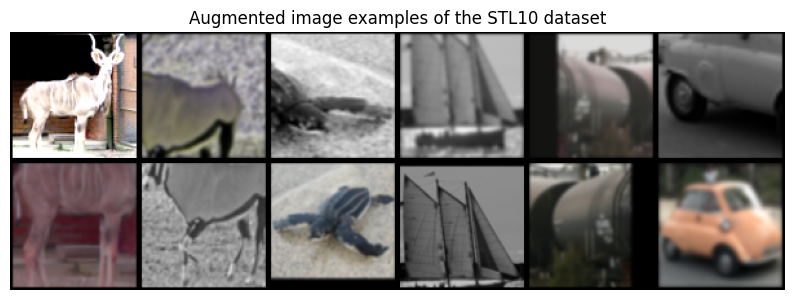

In [65]:
NUM_IMAGES = 6
imgs = np.stack(
    [
        data_prep.parallel_augment(
            random.PRNGKey(idx), np.stack(unlabeled_data[idx][0], axis=0)
        )
        for idx in range(NUM_IMAGES)
    ],
    axis=2,
)
imgs = (imgs + 1.0) / 2.0
img_grid = np.pad(imgs, ((0, 0), (2, 2), (0, 0), (2, 2), (0, 0)))
img_grid = img_grid.reshape(
    img_grid.shape[0] * img_grid.shape[1], -1, img_grid.shape[-1]
)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [66]:
def train_logreg(
    batch_size,
    train_feats_data,
    test_feats_data,
    model_suffix,
    num_epochs=100,
    **kwargs
):
    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        generator=torch.Generator().manual_seed(42),
        collate_fn=numpy_collate,
    )
    test_loader = data.DataLoader(
        test_feats_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=numpy_collate,
    )

    # Create a trainer module with specified hyperparameters
    trainer = LGTrainer(
        exmp_imgs=next(iter(train_loader))[0], model_suffix=model_suffix, **kwargs
    )
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, test_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)

    # Test best model on train and validation set
    train_result = trainer.eval_model(train_loader)
    test_result = trainer.eval_model(test_loader)
    result = {"train": train_result["acc"], "test": test_result["acc"]}

    return trainer, result

In [67]:
def train_simclr(num_epochs=500, **kwargs):
    # Create a trainer module with specified hyperparameters
    train_loader, val_loader = data_prep.get_data_loaders()
    sim_trainer = trainer.SimCLRTrainer(
        exmp_imgs=data_prep.parallel_augment(
            random.PRNGKey(0), next(iter(train_loader))
        ),
        **kwargs
    )
    if not sim_trainer.checkpoint_exists():  # Skip training if pretrained model exists
        sim_trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        sim_trainer.load_model()
    else:
        sim_trainer.load_model(pretrained=True)
    return trainer

In [ ]:
simclr_trainer = train_simclr(hidden_dim=128,
                              lr=5e-4, 
                              temperature=0.07, 
                              weight_decay=1e-4, 
                              num_epochs=50)

Files already downloaded and verified
Files already downloaded and verified
